In [1]:
from pymskt.mesh import BoneMesh, Mesh
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
from pymskt.image import create_vtk_image
from pymskt.image.cartilage_processing import (
    combine_depth_region_segs, get_knee_segmentation_with_femur_subregions
)

In [2]:
location_seg = r'D:\Marco_data_and_code\Projects\quiba_dess_mensa_rachel\data\16103_S10_10102024\ELAB2\R1-qDESS\all.nii.gz'
seg = sitk.ReadImage(location_seg)
seg_array = sitk.GetArrayFromImage(seg)

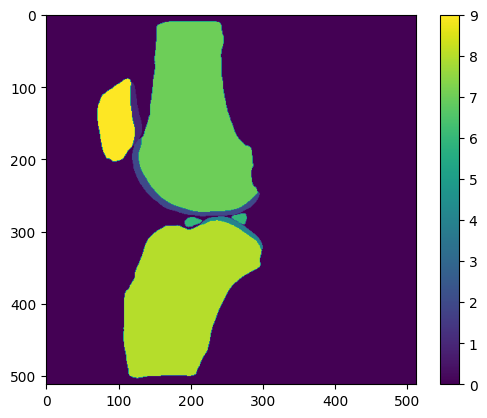

In [12]:
plt.imshow(seg_array[30, :, :])
plt.colorbar()
plt.show()

In [16]:
# initiate the bone mesh object
femur = BoneMesh(path_seg_image=location_seg,  # path to the segmentation iamge being used
                 label_idx=7,                  # what is the label of this bone
                 list_cartilage_labels=[2])    # a list of labels for cartialge associated w/ this bone

# Create the bone mesh
femur.create_mesh(
    smooth_image_var=1.0       # This is the variance of the gaussian filter applied to binary image b4 meshing
)

# Resample the bone surface to have a specified number of nodes. 
femur.resample_surface(
    clusters=20000             # This is the number of nodes/vertices on the surface. It might vary slightly
)

femur_new_seg, femur_rel_depth = femur.break_cartilage_into_superficial_deep(rel_depth_thresh=0.5, return_rel_depth=True, resample_cartilage_surface=10_000)

File does not exist.
File does not exist.
(9980, 3)
(19995, 3)
number of intersections: 5191


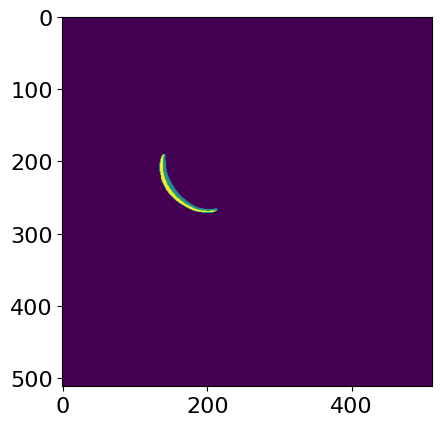

In [18]:
import dosma as dm
dm_femur_new_seg = dm.MedicalVolume.from_sitk(femur_new_seg, copy=True, transpose_inplane=True)

# plot the new segmentation
plt.imshow(dm_femur_new_seg.volume[:, :, 40])
plt.show()


In [19]:
tibia = BoneMesh(path_seg_image=location_seg, label_idx=8, list_cartilage_labels=[3,4])
tibia.create_mesh(smooth_image_var=1.0)
tibia.resample_surface(clusters=20_000)
tibia_new_seg, tibia_rel_depth = tibia.break_cartilage_into_superficial_deep(rel_depth_thresh=0.5, return_rel_depth=True, resample_cartilage_surface=10_000)

File does not exist.
File does not exist.
File does not exist.
(9980, 3)
(19994, 3)
number of intersections: 5136
(9974, 3)
(19994, 3)
number of intersections: 5047


In [20]:
patella = BoneMesh(path_seg_image=location_seg, label_idx=9, list_cartilage_labels=[1])
patella.create_mesh(smooth_image_var=1.0)
patella.resample_surface(clusters=20_000)
patella_new_seg, patella_rel_depth = patella.break_cartilage_into_superficial_deep(rel_depth_thresh=0.5, return_rel_depth=True, resample_cartilage_surface=10_000)


File does not exist.
File does not exist.
(9997, 3)
(19990, 3)
number of intersections: 5314


In [21]:
# read in the segmentation image & break it up into femoral cartilage sub-regions. 
seg_image_orig = sitk.ReadImage(location_seg)
seg_image_subregions = get_knee_segmentation_with_femur_subregions(seg_image_orig)

mid_fem_y is deprecated and not used.
Mean of empty slice.
invalid value encountered in scalar divide


Exception: Middle of med and lat tibial cartilage on same side of centerline!

In [8]:
new_seg_combined = combine_depth_region_segs(
    seg_image_subregions,
    [patella_new_seg, tibia_new_seg, femur_new_seg],
)

In [9]:
sitk.WriteImage(new_seg_combined, 'new_seg_combined_femur_subregions_depth.nrrd')